In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import gzip
import re
import sys

In [3]:
# Input
projectDir = Path("/home/_shared/jscliu/project/2025/Flagship/analysis/secondary/dominant")
known_var_csv = projectDir/"01.known_small_variants/summary/dominant.known_variants.tsv"
novel_var_csv = projectDir/"02.novel_small_variants/summary/dominant.novel_variants.tsv"

# Reference
referenceDir = Path("/home/_shared/jscliu/project/2025/Flagship/reference")
cohort_founder_list = referenceDir/"cohort_founder_list.2024-11-12.csv"
sample_info_csv = referenceDir/"sample_info_annot.2024-11-12.csv"
vcf_headers = referenceDir/"hkgi_dominant.vcf_headers.txt"

# Output
query_vcf_dir = projectDir/"03.filtering/results"
query_vcf_dir.mkdir(exist_ok=True)

# Ouput filtered CSV
out_csv = projectDir/"03.filtering/summary/filtered_variants.dominant.csv"

In [4]:
# Read input CSV as df
known_var_df = pd.read_table(known_var_csv)
novel_var_df = pd.read_table(novel_var_csv)

# Concat known_var_df and novel_var_df

In [17]:
known_var_df['known'] = 'clinvar'
known_var_df['consequence_class'] = np.nan
known_var_df.drop(columns=['AC'], inplace=True)

In [18]:
novel_var_df['known'] = 'novel'
novel_var_df['clinical_relevance'] = np.nan
novel_var_df['clinVar_ID'] = np.nan
novel_var_df['goldstars_n'] = np.nan
novel_var_df.drop(columns=['N_All'], inplace=True)

In [22]:
concat_cols:list = [
    'CPRA', 'CHROM', 'POS', 'REF', 'ALT',
    'known', 'Gene',
    'HGVSc', 'HGVSp', 'Consequence', 'consequence_class', 
    'REVEL', 'SpliceAI',
    'clinVar_ID', 'clinical_relevance', 'goldstars_n', 
    'participant_id', 'GT', 'AD'
]
af_df = pd.concat([
    known_var_df.loc[:, concat_cols], 
    novel_var_df.loc[:, concat_cols]
]).set_index('CPRA')

In [24]:
for col in ['participant_id', 'GT', 'AD']:
    af_df[col] = af_df[col].apply(lambda x: x.split('.'))

In [31]:
# Get query VCF
af_vcf_df = af_df.rename(columns={"CHROM": "#CHROM"}).explode(['participant_id', 'GT', 'AD'])
af_vcf_df['ID'] = af_vcf_df.index
for col in vcf_columns[-3:]:
    af_vcf_df[col] = "."

In [34]:
vcf_columns:list = ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"]
for id in tqdm(af_vcf_df['participant_id'].unique()):
    query_vcf = query_vcf_dir/f"{id}.query.vcf"
    tmp_vcf_df = af_vcf_df.loc[af_vcf_df['participant_id']==id, vcf_columns].copy()
    shutil.copy(vcf_header, query_vcf)
    tmp_vcf_df.to_csv(query_vcf, index=False, sep='\t', mode='a')

100%|█████████████████████████████████████| 18258/18258 [09:08<00:00, 33.32it/s]


# Run 02.retrieve_gatk_info.sh to retrieve INFO fields from raw VCF

In [ ]:
# False pause to run 02.retrieve_gatk_info.sh first before proceeding
sys.exit()

# Read and extract GATK INFO from the query VCF

In [36]:
def read_gatk_vcf(vcf_gz:Path):
    with gzip.open(vcf_gz, 'r') as f:
        vcf_columns:list = ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT", "GT"]
        gatk_df = pd.read_table(f, comment='#', names=vcf_columns)
    gatk_df['participant_id'] = vcf_gz.name.split('.')[0]
    return gatk_df

gatk_vcf_ls:list = list()
for vcf_gz in tqdm(query_vcf_dir.glob("*.gatk_info.vcf.gz")):
    gatk_vcf_ls.append(read_gatk_vcf(vcf_gz))

gatk_vcf_df = pd.concat(gatk_vcf_ls).reset_index(drop=True)

# Merge gatk_vcf_df to af_vcf_df

In [86]:
def set_idcp_index(df):
    df['ID_CP'] = df.apply(lambda r: f"{r['#CHROM']}-{r.POS}-{r.participant_id}", axis=1)
    return df.set_index('ID_CP', drop=True)

gatk_vcf_df = set_idcp_index(gatk_vcf_df)
all_var_df = set_idcp_index(af_vcf_df)

In [120]:
# Merge gatk_vcf_df to all_var_df 
matched_df = all_var_df.drop(columns=['GT', 'AD', 'QUAL', 'FILTER', 'INFO']).merge(
    gatk_vcf_df.drop(columns=["#CHROM", "POS", "ID", "FILTER", "participant_id"]), 
    left_index=True, right_index=True, 
    suffixes=("", "_gatk"), how='inner'
)

In [122]:
# Fix the REF_gatk and ALT_gatk columns for variants from multiallelic sites
def fix_multiallelic_ref_alt(row:pd.Series):
    ref_gatk = row["REF_gatk"]
    alt_gatk = row["ALT_gatk"]
    while ref_gatk[-1] == alt_gatk[-1]:
        ref_gatk = ref_gatk[:-1]
        alt_gatk = alt_gatk[:-1]
    return pd.Series([ref_gatk, alt_gatk])
matched_df[['REF_gatk', 'ALT_gatk']] = matched_df.apply(lambda r: fix_multiallelic_ref_alt(r), axis=1)

In [124]:
# Only keep entries which both REF and ALT match: those mismatched are multiallelic variants where the genomic positions match
matched_df['matched_REF'] = matched_df.apply(lambda r: True if r.REF==r.REF_gatk else False, axis=1)
matched_df['matched_ALT'] = matched_df.apply(lambda r: True if r.ALT==r.ALT_gatk else False, axis=1)
matched_biallelic_df = matched_df.loc[(matched_df['matched_REF']) & (matched_df['matched_ALT']), :].copy()

# Extract information from "INFO" and "FORMAT" columns

In [129]:
def extract_gt(format, gt):
    gt_d = { a[0]: a[1] for a in zip(format.split(':'), gt.split(':')) }
    return pd.Series([gt_d['GT'], gt_d['AD'], int(gt_d['DP']), int(gt_d['GQ']), gt_d['PL']])
matched_biallelic_df[['GT', 'AD', 'DP', 'GQ', 'PL']] = matched_biallelic_df.apply(lambda r: extract_gt(r['FORMAT'], r['GT']), axis=1)

In [130]:
def extract_info(x):
    info_d = { y.split('=')[0]: y.split('=')[1] for y in x.split(';') }
    BaseQRankSum = float(info_d['BaseQRankSum']) if 'BaseQRankSum' in info_d.keys() else np.nan
    ExcessHet = float(info_d['ExcessHet']) if 'ExcessHet' in info_d.keys() else np.nan
    FS = float(info_d['FS']) if 'FS' in info_d.keys() else np.nan
    MLEAC = float(info_d['MLEAC']) if 'MLEAC' in info_d.keys() else np.nan
    MLEAF = float(info_d['MLEAF']) if 'MLEAF' in info_d.keys() else np.nan
    MQ = float(info_d['MQ']) if 'MQ' in info_d.keys() else np.nan
    MQRankSum = float(info_d['MQRankSum']) if 'MQRankSum' in info_d.keys() else np.nan
    QD = float(info_d['QD']) if 'QD' in info_d.keys() else np.nan
    ReadPosRankSum = float(info_d['ReadPosRankSum']) if 'ReadPosRankSum' in info_d.keys() else np.nan
    SOR = float(info_d['SOR']) if 'SOR' in info_d.keys() else np.nan
    
    return pd.Series([
        BaseQRankSum, 
        ExcessHet, 
        FS, 
        MLEAC, 
        MLEAF, 
        MQ,  
        MQRankSum, 
        QD, 
        ReadPosRankSum, 
        SOR
    ])
matched_biallelic_df[['BaseQRankSum', 'ExcessHet', 'FS', 'MLEAC', 'MLEAF', 'MQ', 'MQRankSum', 'QD', 'ReadPosRankSum', 'SOR']] = matched_biallelic_df['INFO'].apply(extract_info)

In [136]:
matched_biallelic_df['GT'] = matched_biallelic_df['GT'].apply(lambda x: "0/1" if x=="1/0" else x)

In [139]:
# Allele depth of ALT allele
matched_biallelic_df['ALT_AD'] = matched_biallelic_df.apply(lambda r: sum(
    [int(i[1]) for i in zip(re.split(r"[/|]", r.GT), r['AD'].split(',')) if int(i[0])==1]
), axis=1)

In [141]:
# Allele depth ratio of ALT to REF
def cal_alt_AD_ratio(r):
    AD_ALL = sum([int(i[1]) for i in zip(re.split(r"[/|]", r.GT), r['AD'].split(','))])
    AD_ALT = sum([int(i[1]) for i in zip(re.split(r"[/|]", r.GT), r['AD'].split(',')) if int(i[0])==1])
    if AD_ALL==0:
        return 1
    else:
        return AD_ALT/AD_ALL
matched_biallelic_df['alt_AD_ratio'] = matched_biallelic_df.apply(lambda r: cal_alt_AD_ratio(r), axis=1)

In [ ]:
dist_df = matched_biallelic_df.reset_index(drop=True)

# Determine if the variants are SNVs or INDELs
dist_df['is_snv'] = dist_df.apply(lambda r: True if len(r.REF)==len(r.ALT)==1 else False, axis=1)
dist_snv_df = dist_df.loc[dist_df['is_snv'], :].copy()
dist_indel_df = dist_df.loc[~dist_df['is_snv'], :].copy()

# Print out the landscape before filtering
print(f"{len(dist_snv_df) = :,}")
print(f"{len(dist_indel_df) = :,}")

# Applying hard filtering

In [150]:
#####Filters on SNVs
# QD: 2 -> 5
# MQ: 40 -> 55
snv_filters_d:dict = {
    "QD": {"threshold": 5.0, "allowed_range": ">"}, 
    "QUAL": {"threshold": 30.0, "allowed_range": ">"}, 
    "SOR": {"threshold": 3.0, "allowed_range": "<"}, 
    "FS": {"threshold": 60.0, "allowed_range": "<"}, 
    "MQ": {"threshold": 55.0, "allowed_range": ">"}, 
    "MQRankSum": {"threshold": -12.5, "allowed_range": ">"}, 
    "ReadPosRankSum": {"threshold": -8.0, "allowed_range": ">"}
}

# # For SNV
# GATK VariantFiltration \
#     -V ${outputPrefix}.snps.biallelelic.vcf.gz \
#     -filter "QD < 2.0" --filter-name "QD2" \
#     -filter "QUAL < 30.0" --filter-name "QUAL30" \
#     -filter "SOR > 3.0" --filter-name "SOR3" \
#     -filter "FS > 60.0" --filter-name "FS60" \
#     -filter "MQ < 40.0" --filter-name "MQ40" \
#     -filter "MQRankSum < -12.5" --filter-name "MQRankSum-12.5" \
#     -filter "ReadPosRankSum < -8.0" --filter-name "ReadPosRankSum-8" \
#     -O ${outputPrefix}.snps_annotated.biallelelic.vcf.gz


#####Filters on INDELs
# QD: 2 -> 5
indel_filters_d:dict = {
    "QD": {"threshold": 5.0, "allowed_range": ">"}, 
    "QUAL": {"threshold": 30.0, "allowed_range": ">"}, 
    "FS": {"threshold": 200.0, "allowed_range": "<"}, 
    "MQ": {"threshold": 55.0, "allowed_range": ">"}, 
    "ReadPosRankSum": {"threshold": -20.0, "allowed_range": ">"}
}

# # For INDEL
# GATK VariantFiltration \
#     -V ${outputPrefix}.indels.biallelelic.vcf.gz \
#     -filter "QD < 2.0" --filter-name "QD2" \
#     -filter "QUAL < 30.0" --filter-name "QUAL30" \
#     -filter "FS > 200.0" --filter-name "FS200" \
#     -filter "ReadPosRankSum < -20.0" --filter-name "ReadPosRankSum-20" \

In [154]:
def plot_distributions_subplots(df, plot_fields):
    fig, ax = plt.subplots(len(plot_fields), 1, figsize=(15, len(plot_fields)*2))
    for i, field in enumerate(plot_fields):
        sns.kdeplot(data=df, x=field, fill=True, ax=ax[i])
        ax[i].set_xlabel("")
        ax[i].set_ylabel(field)
    plt.show()
    return

No. of records failing the QD filter: 16,205
No. of records failing the QUAL filter: 0
No. of records failing the SOR filter: 14,988
No. of records failing the FS filter: 1,810
No. of records failing the MQ filter: 4,624
No. of records failing the MQRankSum filter: 0
No. of records failing the ReadPosRankSum filter: 0
No. of UNIQUE variant records failing any filter: 22,994
Change in variant records: 166,013 -> 143,019 (-13.85%)
Change in variant number: 22,949 -> 21,548 (-6.10%)


/tmp/ipykernel_3529859/172094370.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=field, fill=True, ax=ax[i])


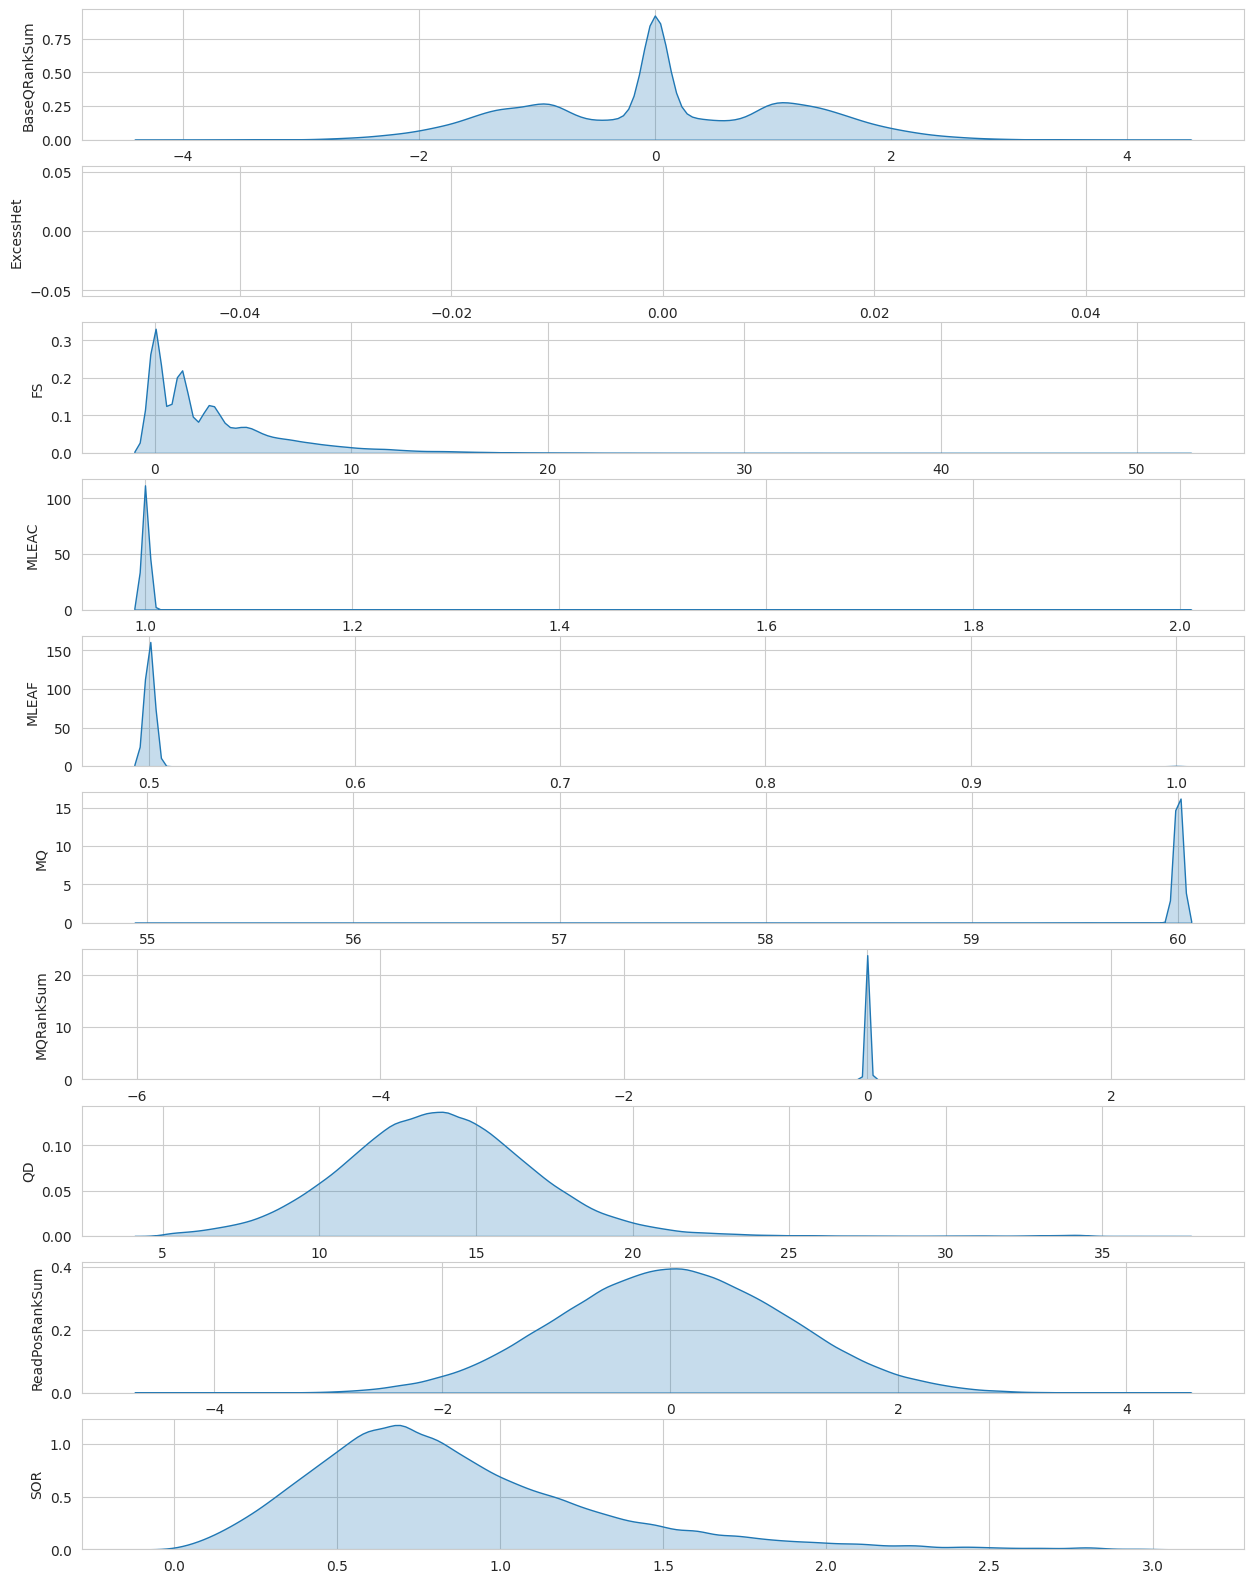

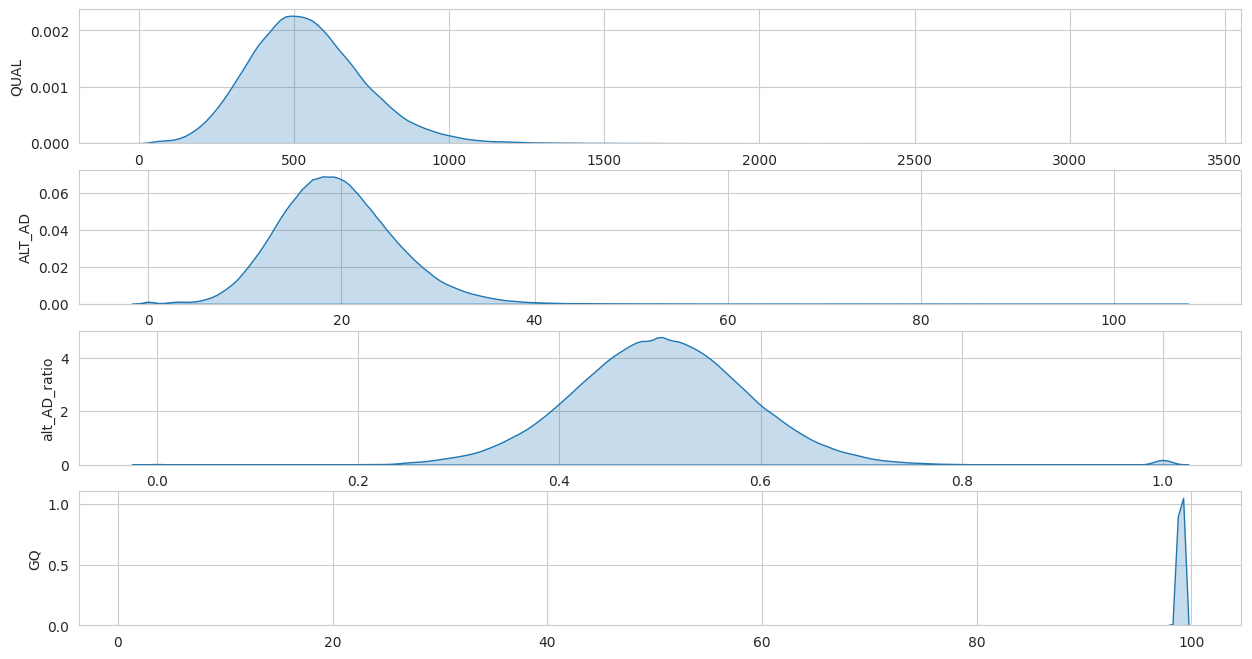

In [156]:
##### Filter SNVs
filtered_snv_df = dist_snv_df.reset_index(drop=True)
drop_indices:set = set()
for key, hard_filter in snv_filters_d.items():
    threshold = hard_filter['threshold']
    allowed_range = hard_filter['allowed_range']
    if allowed_range == ">":
        key_drop_indices:list = filtered_snv_df.loc[filtered_snv_df[key]<threshold, :].index.tolist()
    elif allowed_range == "<":
        key_drop_indices:list = filtered_snv_df.loc[filtered_snv_df[key]>threshold, :].index.tolist()
    print(f"No. of records failing the {key} filter: {len(key_drop_indices):,}")
    drop_indices = drop_indices | set(key_drop_indices)
print(f"No. of UNIQUE variant records failing any filter: {len(drop_indices):,}")

# Apply filter
keep_indices:set = set(filtered_snv_df.index.tolist()).difference(drop_indices)
filtered_snv_df = filtered_snv_df.loc[sorted(list(keep_indices)), :].copy()

# Print out the change
pre_nVarRecords:int = len(dist_snv_df)
post_nVarRecords:int = len(filtered_snv_df)
print(f"Change in variant records: {pre_nVarRecords:,} -> {post_nVarRecords:,} ({(post_nVarRecords-pre_nVarRecords)*100/pre_nVarRecords:.2f}%)")
pre_nVar:int = len(dist_snv_df['ID'].unique())
post_nVar:int = len(filtered_snv_df['ID'].unique())
print(f"Change in variant number: {pre_nVar:,} -> {post_nVar:,} ({(post_nVar-pre_nVar)*100/pre_nVar:.2f}%)")
# Plot
plot_distributions_subplots(filtered_snv_df, plot_INFO_fields)
plot_distributions_subplots(filtered_snv_df, plot_FORMAT_fields)

No. of records failing the QD filter: 2,857
No. of records failing the QUAL filter: 0
No. of records failing the FS filter: 0
No. of records failing the MQ filter: 270
No. of records failing the ReadPosRankSum filter: 0
No. of UNIQUE variant records failing any filter: 3,124
Change in variant records: 12,974 -> 9,850 (-24.08%)
Change in variant number: 2,820 -> 1,645 (-41.67%)


/tmp/ipykernel_3529859/172094370.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=field, fill=True, ax=ax[i])


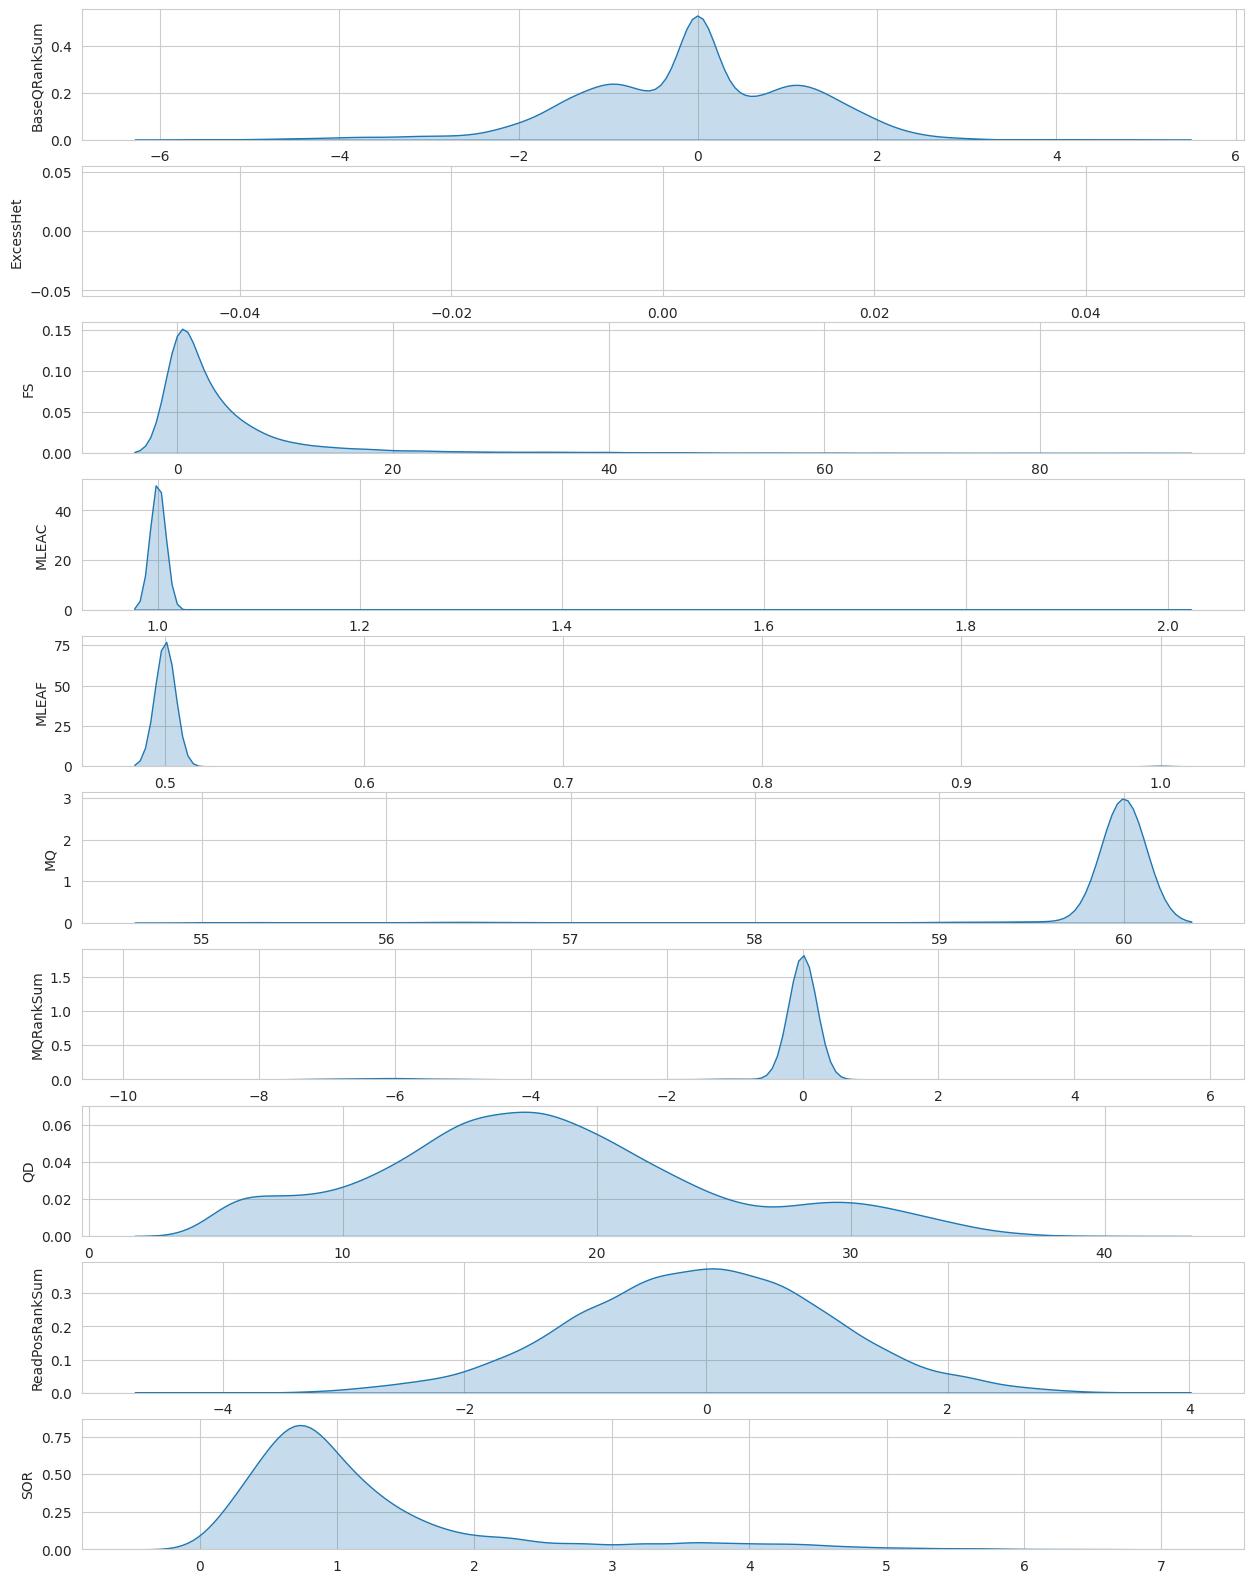

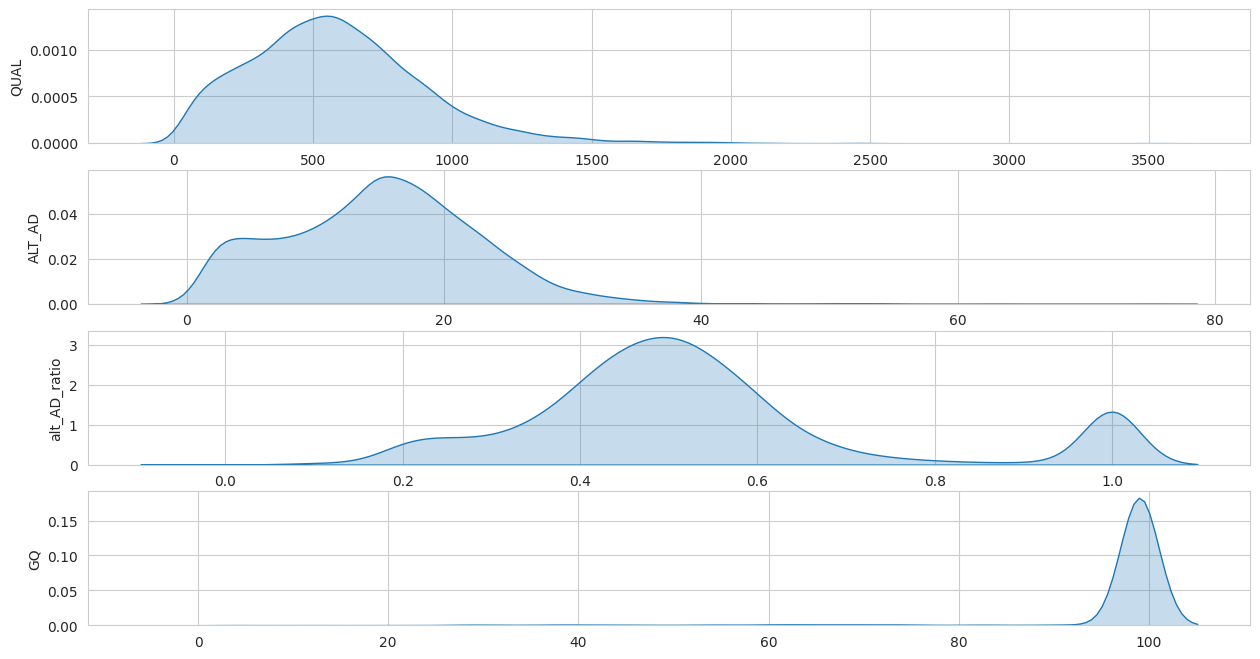

In [157]:
##### Filter INDELs
filtered_indel_df = dist_indel_df.reset_index(drop=True)
drop_indices:set = set()
for key, hard_filter in indel_filters_d.items():
    threshold = hard_filter['threshold']
    allowed_range = hard_filter['allowed_range']
    if allowed_range == ">":
        key_drop_indices:list = filtered_indel_df.loc[filtered_indel_df[key]<threshold, :].index.tolist()
    elif allowed_range == "<":
        key_drop_indices:list = filtered_indel_df.loc[filtered_indel_df[key]>threshold, :].index.tolist()
    print(f"No. of records failing the {key} filter: {len(key_drop_indices):,}")
    drop_indices = drop_indices | set(key_drop_indices)
print(f"No. of UNIQUE variant records failing any filter: {len(drop_indices):,}")

# Apply filter
keep_indices:set = set(filtered_indel_df.index.tolist()).difference(drop_indices)
filtered_indel_df = filtered_indel_df.loc[sorted(list(keep_indices)), :].copy()

# Print out the change
pre_nVarRecords:int = len(dist_indel_df)
post_nVarRecords:int = len(filtered_indel_df)
print(f"Change in variant records: {pre_nVarRecords:,} -> {post_nVarRecords:,} ({(post_nVarRecords-pre_nVarRecords)*100/pre_nVarRecords:.2f}%)")
pre_nVar:int = len(dist_indel_df['ID'].unique())
post_nVar:int = len(filtered_indel_df['ID'].unique())
print(f"Change in variant number: {pre_nVar:,} -> {post_nVar:,} ({(post_nVar-pre_nVar)*100/pre_nVar:.2f}%)")
# Plot
plot_distributions_subplots(filtered_indel_df, plot_INFO_fields)
plot_distributions_subplots(filtered_indel_df, plot_FORMAT_fields)

In [158]:
# Visualize the INDEL length pre- and post-filtering
def cal_indel_length(ref, alt):
    ref_len = len(ref)
    alt_len = len(alt)
    indel = 'ins' if alt_len > ref_len else 'del'
    return pd.Series([abs(alt_len-ref_len), indel])
    
dist_indel_df[['indel_len', 'type']] = dist_indel_df.apply(lambda r: cal_indel_length(r.REF, r.ALT), axis=1)
filtered_indel_df[['indel_len', 'type']] = filtered_indel_df.apply(lambda r: cal_indel_length(r.REF, r.ALT), axis=1)

In [159]:
# Pre-filter
pre_filter_indel_len_df = dist_indel_df[['indel_len', 'type']]
pre_filter_indel_len_df.loc[:, ['source']] = 'Pre-filter'
# Post-filter
post_filter_indel_len_df = filtered_indel_df[['indel_len', 'type']]
post_filter_indel_len_df.loc[:, ['source']] = 'Post-filter'

# Concat and plot
comp_indel_len_df = pd.concat([pre_filter_indel_len_df, post_filter_indel_len_df])

Text(0, 0.5, '')

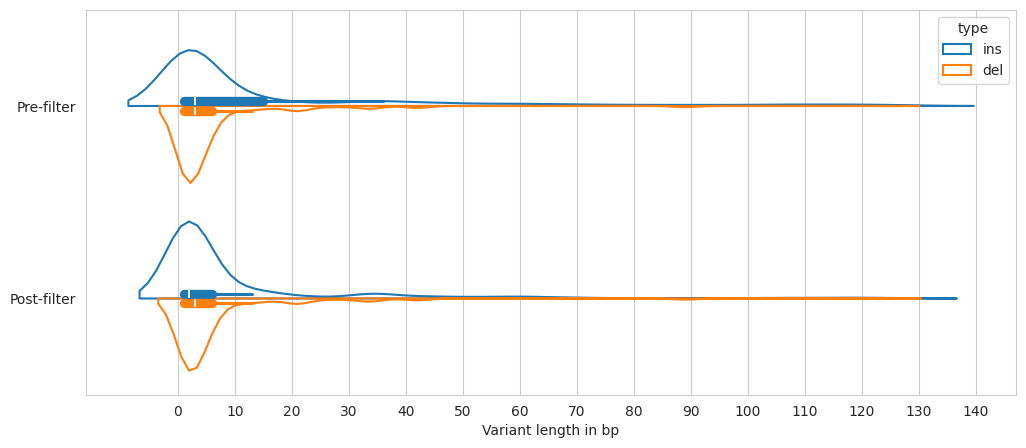

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.violinplot(data=comp_indel_len_df, y='source', x='indel_len', hue='type', split=True, fill=False)
ax.set_xticks(range(0, 150, 10), labels=range(0, 150, 10))
ax.set_xlabel("Variant length in bp")
ax.set_ylabel("")

# Consolidate all information regarding the variants passing the filters

In [164]:
# Calculate AC, AN, AF, N_Het, N_Hom, N_Hem, N_All, prevalence from column "AC" and "AN"
def cal_freq(ac_ls:list, ploidy_ls:list, chr:str, n_male:int, n_female:int):
    ac = sum(ac_ls)
    an = n_male + 2*n_female if chr=='chrX' else 2*(n_male+n_female)
    af = ac/an
    N_Het, N_Hom, N_Hem = 0, 0, 0
    for tmp_ac, tmp_ploidy in zip(ac_ls, ploidy_ls):
        if (tmp_ac==1) & (tmp_ploidy=='haploid'):
            N_Hem+=1
        elif (tmp_ac==1) & (tmp_ploidy=='diploid'):
            N_Het+=1
        elif (tmp_ac==2) & (tmp_ploidy=='diploid'):
            N_Hom+=1
        else:
            sys.exit()    # System exit because it's unexpected
    N_All = N_Het + N_Hom + N_Hem
    if N_All == 1:
        prevalence = 'private'
    elif af < 0.05:
        prevalence = 'rare'
    else:
        prevalence = 'common'
    return pd.Series([ac, an, af, N_Het, N_Hom, N_Hem, N_All, prevalence])

In [165]:
# Get the number of male and female in all unrelated individuals
sample_info_df = pd.read_csv(sample_info_csv).set_index('sre_participant_id')
with open(cohort_founder_list, 'r') as f:
    cohort_founders_ls = [ line.strip().split(',')[0] for line in f ]

n_male = sample_info_df.loc[cohort_founders_ls, 'inferred_sex'].value_counts()['Male']
n_female = sample_info_df.loc[cohort_founders_ls, 'inferred_sex'].value_counts()['Female']

### Pre-process df for SNVs

In [167]:
keep_cols:list = [
    'ID', '#CHROM', 'POS', 'REF', 'ALT', 'Gene', 'known', 
    'QUAL', 'QD', 'SOR', 'FS', 'MQ', 
    'participant_id', 'GT', 'AD', 'DP', 'GQ', 'PL'
]
filtered_snv_var_df = filtered_snv_df.loc[:, keep_cols].copy()
filtered_snv_var_df.fillna(".", inplace=True)

In [168]:
# Deduce AC and ploidy from GT
filtered_snv_var_df['AC'] = filtered_snv_var_df['GT'].apply(lambda x: re.split(r'[/|]', x).count('1'))
filtered_snv_var_df['ploidy'] = filtered_snv_var_df['GT'].apply(lambda x: 'diploid' if len(re.split(r'[/|]', x))==2 else 'haploid')

In [169]:
# Concat QD, SOR, FS, MQ to "variant_info_record"
filtered_snv_var_df['variant_info_record'] = filtered_snv_var_df.apply(
    lambda r: f"QD={r.QD};SOR={r.SOR};FS={r.FS};MQ={r.MQ}", 
    axis=1
)
filtered_snv_var_df.drop(columns=['QD', 'SOR', 'FS', 'MQ'], inplace=True)

In [170]:
# Concat GT, AD, DP, FQ, PL to "variant_record"
filtered_snv_var_df['FORMAT'] = "GT:AD:DP:GQ:PL"
filtered_snv_var_df['variant_record'] = filtered_snv_var_df.apply(
    lambda r: f"{r.GT}:{r.AD}:{r.DP}:{r.GQ}:{r.PL}", 
    axis=1
)
filtered_snv_var_df.drop(columns=['GT', 'AD', 'DP', 'GQ', 'PL'], inplace=True)

In [171]:
filtered_snv_var_df = filtered_snv_var_df.groupby('ID').agg(list)
variant_unique_cols:list = ["#CHROM", 'POS', 'REF', 'ALT', 'Gene', 'known', 'FORMAT']
for col in variant_unique_cols:
    filtered_snv_var_df[col] = filtered_snv_var_df[col].apply(lambda x: x[0])

In [172]:
filtered_snv_var_df[['AC', 'AN', 'AF', 'N_Het', 'N_Hom', 'N_Hem', 'N_All', 'prevalence']] = filtered_snv_var_df.apply(
    lambda r: cal_freq(r.AC, r.ploidy, r['#CHROM'], n_male, n_female), 
    axis=1
)

### Pre-process df for INDELs

In [173]:
keep_cols:list = [
    'ID', '#CHROM', 'POS', 'REF', 'ALT', 'Gene', 'known', 
    'QUAL', 'QD', 'SOR', 'FS', 'MQ', 
    'participant_id', 'GT', 'AD', 'DP', 'GQ', 'PL'
]
filtered_indel_var_df = filtered_indel_df.loc[:, keep_cols].copy()
filtered_indel_var_df.fillna(".", inplace=True)

In [174]:
# Deduce AC and ploidy from GT
filtered_indel_var_df['AC'] = filtered_indel_var_df['GT'].apply(lambda x: re.split(r'[/|]', x).count('1'))
filtered_indel_var_df['ploidy'] = filtered_indel_var_df['GT'].apply(lambda x: 'diploid' if len(re.split(r'[/|]', x))==2 else 'haploid')

In [175]:
# Concat QD, SOR, FS, MQ to "variant_info_record"
filtered_indel_var_df['variant_info_record'] = filtered_indel_var_df.apply(
    lambda r: f"QD={r.QD};SOR={r.SOR};FS={r.FS};MQ={r.MQ}", 
    axis=1
)
filtered_indel_var_df.drop(columns=['QD', 'SOR', 'FS', 'MQ'], inplace=True)

In [176]:
# Concat GT, AD, DP, FQ, PL to "variant_record"
filtered_indel_var_df['FORMAT'] = "GT:AD:DP:GQ:PL"
filtered_indel_var_df['variant_record'] = filtered_indel_var_df.apply(
    lambda r: f"{r.GT}:{r.AD}:{r.DP}:{r.GQ}:{r.PL}", 
    axis=1
)
filtered_indel_var_df.drop(columns=['GT', 'AD', 'DP', 'GQ', 'PL'], inplace=True)

In [177]:
filtered_indel_var_df = filtered_indel_var_df.groupby('ID').agg(list)
variant_unique_cols:list = ["#CHROM", 'POS', 'REF', 'ALT', 'Gene', 'known', 'FORMAT']
for col in variant_unique_cols:
    # print(col)
    filtered_indel_var_df[col] = filtered_indel_var_df[col].apply(lambda x: x[0])

In [178]:
filtered_indel_var_df[['AC', 'AN', 'AF', 'N_Het', 'N_Hom', 'N_Hem', 'N_All', 'prevalence']] = filtered_indel_var_df.apply(
    lambda r: cal_freq(r.AC, r.ploidy, r['#CHROM'], n_male, n_female), 
    axis=1
)

## Concat SNV and INDEL records

In [179]:
filtered_var_df = pd.concat([filtered_snv_var_df, filtered_indel_var_df]).sort_index()

In [189]:
# Merge such revised af df (filtered_var_df) to the original carrier_filtered_df to get the variant-specific information
var_info_cols:list = [
    'HGVSc','HGVSp', 'Consequence', 'consequence_class', 'REVEL', 'SpliceAI',
    'clinVar_ID', 'clinical_relevance', 'goldstars_n'
]
filtered_var_full_df = filtered_var_df.merge(
    af_df.loc[:, var_info_cols], 
    left_index=True, right_index=True, 
    suffixes=("", "_unfiltered"), how='inner'
).rename(columns={
    'Gene': 'dominant_gene', 
})

In [195]:
filtered_var_full_columns:list = [
    '#CHROM', 'POS', 'REF', 'ALT', 'dominant_gene', 'known', 'clinVar_ID', 'HGVSc', 'HGVSp', 
    'Consequence', 'consequence_class', 'clinical_relevance', 'goldstars_n', 'REVEL', 'SpliceAI', 
    'AF', 'AC', 'AN', 'N_Het', 'N_Hom', 'N_Hem', 'N_All', 'prevalence',
    'participant_id', 'QUAL', 'variant_info_record', 'FORMAT', 'variant_record',    
]

filtered_var_full_df = filtered_var_full_df.loc[:, filtered_var_full_columns].copy()

In [203]:
# Process certain columns before exporting to CSV
export_df = filtered_var_full_df.drop(columns=['#CHROM', 'POS', 'REF', 'ALT'])
export_df['clinVar_ID'] = export_df['clinVar_ID'].apply(
    lambda x: np.nan if pd.isna(x) else str(int(x))
)
listed_cols:list = ['participant_id', 'QUAL', 'variant_info_record', 'variant_record']
for col in listed_cols:
    export_df[col] = export_df[col].apply(lambda x: "%".join([str(y) for y in x]))

In [205]:
export_df.to_csv(out_csv, index=True, index_label="Chr.Pos.Ref.Alt")